In [1]:

!pip install transformers scikit-learn pandas numpy torch tqdm nltk --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.9 MB/s eta 0:00:00


In [11]:
# 📚 STEP 1: Import libraries
import pandas as pd
import numpy as np
import torch
from transformers import DistilBertTokenizerFast, DistilBertModel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Load datasets
fake_df = pd.read_csv("Fake.csv")
true_df = pd.read_csv("True.csv")

# Add labels
fake_df["label"] = 0
true_df["label"] = 1

# Combine and shuffle
df = pd.concat([fake_df, true_df], ignore_index=True)
df = df[["title", "text", "label"]].dropna()
df["content"] = df["title"] + " " + df["text"]
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Optional: Use smaller sample for quick test
# df = df.sample(n=2000, random_state=42)


In [4]:
# Load DistilBERT
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
bert_model = DistilBertModel.from_pretrained("distilbert-base-uncased")

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)
bert_model.eval()
# Function to get [CLS] embeddings
def get_bert_cls_embeddings(texts, batch_size=16, max_length=512):
    embeddings = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Embedding"):
        batch = texts[i:i + batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = bert_model(**inputs)
            cls_embed = outputs.last_hidden_state[:, 0, :]  # CLS token

        embeddings.append(cls_embed.cpu())

    return torch.cat(embeddings).numpy()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [5]:
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df["content"], df["label"], test_size=0.2, stratify=df["label"], random_state=42
)

# Embed with DistilBERT
X_train_embed = get_bert_cls_embeddings(X_train_text.tolist())
X_test_embed = get_bert_cls_embeddings(X_test_text.tolist())


Embedding: 100%|██████████| 562/562 [02:19<00:00,  4.03it/s]


In [6]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_embed, y_train)


LogisticRegression(max_iter=1000)

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4696
           1       0.99      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

Confusion Matrix:

[[4667   29]
 [  24 4260]]


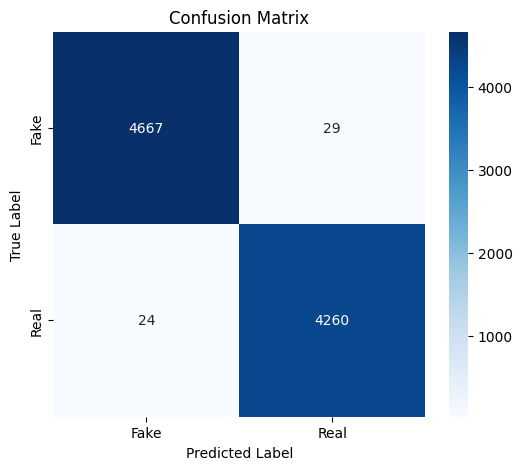

In [12]:
y_pred = clf.predict(X_test_embed)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['Fake', 'Real']

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [13]:
def predict_news(news_text):
    encoded = tokenizer(news_text, return_tensors='pt', truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        output = bert_model(**encoded)
        cls_embed = output.last_hidden_state[:, 0, :].cpu().numpy()
    pred = clf.predict(cls_embed)[0]
    return "🟢 Real News" if pred == 1 else "🔴 Fake News"

# Try a sample
print(predict_news("Government announces new economic policies for farmers."))


🟢 Real News
